# Analysis of Anna Karenina data

### Import dependencies

In [67]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib import pyplot as plt
import seaborn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import gseapy as gp
from matplotlib_venn import venn2
from matplotlib.patches import Patch
import seaborn as sns
import importlib


PALETTE = [
    "#0652ff", #  electric blue
    "#e50000", #  red
    "#9a0eea", #  violet
    "#01b44c", #  shamrock
    "#fedf08", #  dandelion
    "#00ffff", #  cyan
    "#89fe05", #  lime green
    "#a2cffe", #  baby blue
    "#dbb40c", #  gold
    "#029386", #  teal
    "#ff9408", #  tangerine
    "#d8dcd6", #  light grey
    "#80f9ad", #  seafoam
    "#3d1c02", #  chocolate
    "#fffd74", #  butter yellow
    "#536267", #  gunmetal
    "#f6cefc", #  very light purple
    "#650021", #  maroon
    "#020035", #  midnight blue
    "#b0dd16", #  yellowish green
    "#9d7651", #  mocha
    "#c20078", #  magenta
    "#380282", #  indigo
    "#ff796c", #  salmon
    "#874c62"  #  dark muave
]

FDR_THRESH = 0.1

def run_analysis(gene_set, cond_1, cond_2, plot_title, deseq_df, out_f, keep_first=True):
    
    da = []
    for gene in gene_set:
        samples = category_to_samples[cond_1]
        for e in df_log2cpm.transpose().loc[samples][gene]:
            da.append((cond_1, gene, e))
        samples = category_to_samples[cond_2]
        for e in df_log2cpm.transpose().loc[samples][gene]:
            da.append((cond_2, gene, e))
    df_barplot = pd.DataFrame(
        data=da,
        columns=['Category', 'Gene', r'Expression ($log_2$(CPM+1))']
    )
    plt.figure(figsize=(0.4*len(gene_set), 3.5))
    sns.boxplot(data=df_barplot, x='Gene', y=r'Expression ($log_2$(CPM+1))', hue='Category')
    plt.xticks(rotation='vertical')

    for gene, k in zip(gene_set, plt.gca().get_xmajorticklabels()):
        if deseq_df.loc[gene]['padj'] < FDR_THRESH and deseq_df.loc[gene]['log2FoldChange'] > 0:
            k.set_color(sns.color_palette()[0])
        elif deseq_df.loc[gene]['padj'] < FDR_THRESH and deseq_df.loc[gene]['log2FoldChange'] < 0:
            k.set_color(sns.color_palette()[1])
        else:
            k.set_color('black')
    plt.title(plot_title, fontsize=15)
    plt.tight_layout()
    plt.savefig(f'{out_f}.tiff', bbox_layout='tight',format='tiff', dpi=200)
    
    ax = plt.gca()
    ticks_font = mpl.font_manager.FontProperties(size=15)
    for label in ax.get_xticklabels():
        label.set_fontproperties(ticks_font)
    plt.xlabel('Gene', fontsize=15)
    plt.ylabel(r'Expression ($log_2$(CPM+1))', fontsize=15)
    plt.show()
    
    # Restrict only to genes that are DE and up in cond_1
    sns.set_palette('colorblind')
    da = []
    for gene in gene_set:
        if keep_first:
            if not(deseq_df.loc[gene]['padj'] < FDR_THRESH and deseq_df.loc[gene]['log2FoldChange'] > 0):
                continue
        else:
            if not(deseq_df.loc[gene]['padj'] < FDR_THRESH and deseq_df.loc[gene]['log2FoldChange'] < 0):
                continue
        samples = category_to_samples[cond_1]
        for e in df_log2cpm.transpose().loc[samples][gene]:
            da.append((cond_1, gene, e))
        samples = category_to_samples[cond_2]
        for e in df_log2cpm.transpose().loc[samples][gene]:
            da.append((cond_2, gene, e))
    if len(da) > 0:
        df_barplot = pd.DataFrame(
            data=da,
            columns=['Category', 'Gene', r'Expression ($log_2$(CPM+1))']
        )
        plt.figure(figsize=(0.4*len(set(df_barplot['Gene'])),3.5))
        sns.boxplot(data=df_barplot, x='Gene', y=r'Expression ($log_2$(CPM+1))', hue='Category')
        plt.xticks(rotation='vertical')
        plt.title(plot_title, fontsize=15)
        plt.tight_layout()
        plt.savefig(f'{out_f}.genes_agree.tiff', bbox_layout='tight',format='tiff', dpi=200)
        ax = plt.gca()
        ticks_font = mpl.font_manager.FontProperties(size=15)
        for label in ax.get_xticklabels():
            label.set_fontproperties(ticks_font)
        plt.xlabel('Gene', fontsize=15)
        plt.ylabel(r'Expression ($log_2$(CPM+1))', fontsize=15)
        plt.show()
        
        


### Load data

In [2]:
#df = pd.read_csv('Normalized_Matrix_rmDuplicates.tsv', sep='\t', index_col=0)
df = pd.read_csv('log2Top15_GE.csv', sep=',', index_col=0)
df = df.transpose()
df

gene_id,0610012H03RIK,1300002K09RIK,1700012B07RIK,1700023E05RIK,1700024P16RIK,1700026L06RIK,1700065D16RIK,1700084C01RIK,1810009J06RIK,1810011H11RIK,...,ZFP850,ZFP872,ZFYVE28,ZG16,ZIM1,ZMAT4,ZMYND10,ZMYND15,ZPLD1,ZRSR1
T729_T2D,2.139972,0.904790,0.886001,3.321288,3.018142,-0.120079,1.039359,0.115235,8.683662,1.616519,...,-0.574708,6.622929,1.575318,6.028198,0.208431,-0.365326,0.392490,1.013058,3.663532,9.740166
T737_T2H,2.139972,5.183519,2.610027,2.585681,0.535294,2.835978,0.290897,2.265794,1.777734,1.616519,...,4.803432,2.628355,1.575318,17.568044,4.001286,4.892439,7.178433,6.799393,-0.251033,5.267107
Q203_E18.5,2.381888,6.241376,3.686575,3.723977,2.008352,6.217215,0.137820,0.935641,-1.883501,-0.875018,...,5.531309,0.997768,2.613695,5.343438,6.101912,0.178346,5.138722,1.220941,4.036839,7.300163
Q204_P1,3.576088,3.045160,-0.131401,2.102020,2.900100,5.698393,3.061920,1.955748,4.057370,-0.875018,...,4.840375,1.108050,0.935311,3.922136,5.377470,4.556858,3.974061,-0.510507,2.212631,6.845432
T222_T1D,2.669653,6.373886,2.111024,2.901908,2.673608,4.953962,1.822244,2.948087,5.426252,4.518148,...,1.454490,4.961630,5.112352,15.193220,4.033178,0.186980,0.551736,8.059444,0.246294,10.065979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q891_T1ND,0.643385,4.559134,-0.345525,0.894127,-0.307793,3.367261,1.628390,5.003919,4.678436,-0.875018,...,4.002335,5.800783,5.333322,12.797213,5.762778,1.668917,5.887894,1.135550,2.495309,9.737797
Q896_T1ND,3.421890,5.464437,4.510464,3.581188,-0.307793,2.884396,0.137820,6.198411,4.475106,-0.187957,...,1.461347,2.335786,3.090182,13.337554,5.603769,0.178346,4.892857,6.525603,0.004738,9.086007
Q897_T1ND,0.739012,6.296940,0.207986,2.901908,-0.227500,3.953962,0.293749,4.417073,4.151909,2.288835,...,4.534383,2.487966,4.938827,13.777370,4.212360,2.219080,4.357436,6.780621,0.246294,9.876403
Q899_T1ND,-0.553769,5.849013,0.207986,5.172643,2.878513,3.572359,2.744410,5.068305,4.861189,-0.741501,...,4.576862,4.909944,3.410696,15.618562,4.492279,0.702995,5.561587,5.625244,0.246294,10.369488


In [3]:
df_counts = pd.read_csv('Raw_Matrix_filter_rmDup.tsv', sep='\t')
df_counts = df_counts.set_index('GENE_ID')
df_counts

,T729_T2D,T737_T2H,Q203_E18.5,Q204_P1,T222_T1D,Q225_T1ND,Q279_T2D_XXX,T286.1_T2H,Q287_WT,Q292_WT,...,Q792_WT,Q819_WT,T843_WT,T880_WT,Q890_WT,Q891_T1ND,Q896_T1ND,Q897_T1ND,Q899_T1ND,Q918_T2H
GENE_ID,,,,,,,,,,,,,,,,,,,,,
0610007P14RIK,1233.00,1212.00,1039.97,1179.96,586.07,465.44,404.90,497.26,590.16,490.99,...,369.03,655.94,752.62,632.23,532.46,717.28,543.89,579.59,378.01,439.85
0610009B22RIK,6048.40,3608.59,3554.90,3224.48,1475.05,1309.53,1348.77,1427.68,1299.68,1846.15,...,1525.98,1570.52,1973.26,1772.51,1641.50,1856.05,1863.37,1309.23,1120.49,1493.43
0610009D07RIK,2608.15,3372.00,6266.52,6086.78,1928.94,1871.15,1517.46,2254.95,2485.87,2210.91,...,2500.21,2293.26,2848.21,2637.55,2210.99,2329.88,1450.88,1841.17,1764.46,2228.42
0610009O20RIK,292.00,480.98,335.45,424.02,200.61,143.00,264.09,209.32,304.65,165.48,...,253.14,284.00,229.58,233.00,209.03,437.00,105.03,225.07,168.41,202.00
0610010F05RIK,1365.00,1127.70,808.69,1056.00,744.33,597.00,1344.31,677.08,1256.51,577.00,...,655.97,628.09,1052.94,1439.23,715.39,722.00,461.00,1456.85,520.59,532.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYX,163.03,281.00,523.00,1686.00,609.00,124.99,229.72,5.07,98.00,50.00,...,91.00,139.00,72.00,112.00,107.00,186.00,268.97,476.01,271.03,143.00
ZZEF1,871.00,1386.00,1087.45,899.73,1070.20,739.58,794.05,526.45,814.36,966.48,...,1032.92,999.06,1093.02,762.83,873.41,1125.93,473.00,667.70,767.61,783.58
ZZZ3,1231.03,1294.00,759.35,1311.79,660.59,623.00,2413.77,753.55,1764.66,902.24,...,1013.43,1134.73,1656.51,1441.79,1052.67,960.32,476.00,1417.36,684.39,484.00


### Organize the data a little bit to make analyses easier

In [4]:
# Map each sample to its category
sample_to_category = {
    sample: sample.split('_')[1]
    for sample in df.index
}

# Map each category to its samples
category_to_samples = defaultdict(lambda: set())
for sample, cat in sample_to_category.items():
    category_to_samples[cat].add(sample)


# Map each sample to its index
sample_to_index = {
    sample: ind
    for ind, sample in enumerate(df.index)
}

In [5]:
category_to_samples.keys()

dict_keys(['T2D', 'T2H', 'E18.5', 'P1', 'T1D', 'T1ND', 'WT', 'P10', 'P7'])

### Process the data with a few algorithms: PCA and Leiden

In [6]:
import scanpy as sc
from anndata import AnnData

X_log = np.array(df)
ad = AnnData(
    X=X_log,
    obs=pd.DataFrame(
        index=df.index,
        data=[
            sample_to_category[sample]
            for sample in df.index
        ],
        columns=['batch']
    ),
    var=pd.DataFrame(
        data=df.columns,
        index=df.columns
    )
)

sc.pp.pca(ad)
sc.pp.neighbors(ad, n_neighbors=4)
sc.tl.umap(ad)
sc.tl.leiden(ad, resolution=1.5)

#### Here's the PCA plot with samples colored by their category/batch

... storing 'batch' as categorical


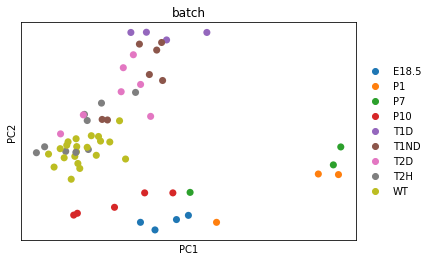

In [7]:
sc.pl.pca(ad, color='batch', s=200)

#### Here's the PCA plot with samples colored by their cluster according to Leiden

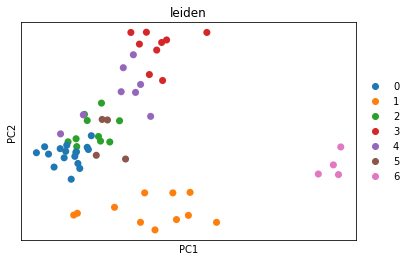

In [8]:
sc.pl.pca(ad, color='leiden', s=200)

## Create Heatmap

In [9]:
WT_VS_DB_plus_UP_WT = [
    #'RN45S',
    #'MIR6236',
    'MT1',
    'SLC2A13',
    'USO1',
    'LYVE1',
    'BRPF3',
    'DCHS1',
    'WNK4',
    'PRR12',
    'CITED2',
    'CRTC1',
    'HEG1',
    'ZBTB20',
    'TNR',
    'PABPC1',
    'CD47',
    'MUC4',
    'HIPK2',
    'EIF4EBP2',
    'UBQLN2',
    'AGO2',
    'GPC4',
    'IREB2',
    'MSLN',
    'ZKSCAN3'
]

WT_VS_DB_plus_UP_DB = [
    'SPINK3', #SPINK1
    'TRY10',
    'SDC4',
    'D1ERTD622E',
    'DDX3Y',
    'COX6A2',
    'IFRD1',
    'H2-Q4',
    'CDK2AP2',
    'BBC3',
    'CRELD2',
    'CHAC1', 
    #'MANF', # Why is this repeated in their paper?
    'NUPR1',
    'RHOB',
    'CYR61',
    'KLF10',
    'KLF6',
    'SRF',
    'JUNB',
    'RBM15B',
    'JUN',
    'MANF',
    'DNAJB1',
    'DNAJA4',
    'NFKBIA'
]

In [10]:
df_counts = pd.read_csv('Raw_Matrix_filter_rmDup.tsv', sep='\t')
df_counts = df_counts.set_index('GENE_ID')
df_counts

,T729_T2D,T737_T2H,Q203_E18.5,Q204_P1,T222_T1D,Q225_T1ND,Q279_T2D_XXX,T286.1_T2H,Q287_WT,Q292_WT,...,Q792_WT,Q819_WT,T843_WT,T880_WT,Q890_WT,Q891_T1ND,Q896_T1ND,Q897_T1ND,Q899_T1ND,Q918_T2H
GENE_ID,,,,,,,,,,,,,,,,,,,,,
0610007P14RIK,1233.00,1212.00,1039.97,1179.96,586.07,465.44,404.90,497.26,590.16,490.99,...,369.03,655.94,752.62,632.23,532.46,717.28,543.89,579.59,378.01,439.85
0610009B22RIK,6048.40,3608.59,3554.90,3224.48,1475.05,1309.53,1348.77,1427.68,1299.68,1846.15,...,1525.98,1570.52,1973.26,1772.51,1641.50,1856.05,1863.37,1309.23,1120.49,1493.43
0610009D07RIK,2608.15,3372.00,6266.52,6086.78,1928.94,1871.15,1517.46,2254.95,2485.87,2210.91,...,2500.21,2293.26,2848.21,2637.55,2210.99,2329.88,1450.88,1841.17,1764.46,2228.42
0610009O20RIK,292.00,480.98,335.45,424.02,200.61,143.00,264.09,209.32,304.65,165.48,...,253.14,284.00,229.58,233.00,209.03,437.00,105.03,225.07,168.41,202.00
0610010F05RIK,1365.00,1127.70,808.69,1056.00,744.33,597.00,1344.31,677.08,1256.51,577.00,...,655.97,628.09,1052.94,1439.23,715.39,722.00,461.00,1456.85,520.59,532.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYX,163.03,281.00,523.00,1686.00,609.00,124.99,229.72,5.07,98.00,50.00,...,91.00,139.00,72.00,112.00,107.00,186.00,268.97,476.01,271.03,143.00
ZZEF1,871.00,1386.00,1087.45,899.73,1070.20,739.58,794.05,526.45,814.36,966.48,...,1032.92,999.06,1093.02,762.83,873.41,1125.93,473.00,667.70,767.61,783.58
ZZZ3,1231.03,1294.00,759.35,1311.79,660.59,623.00,2413.77,753.55,1764.66,902.24,...,1013.43,1134.73,1656.51,1441.79,1052.67,960.32,476.00,1417.36,684.39,484.00


In [11]:
X_log_cpm = np.array([
    x / sum(x)
    for x in np.array(df_counts).T
])
X_log_cpm *= 1e6
X_log_cpm = np.log2(X_log_cpm+1)

df_log2cpm = pd.DataFrame(
    data=X_log_cpm,
    index=df_counts.columns,
    columns=df_counts.index
)
df_log2cpm = df_log2cpm.transpose()
df_log2cpm

,T729_T2D,T737_T2H,Q203_E18.5,Q204_P1,T222_T1D,Q225_T1ND,Q279_T2D_XXX,T286.1_T2H,Q287_WT,Q292_WT,...,Q792_WT,Q819_WT,T843_WT,T880_WT,Q890_WT,Q891_T1ND,Q896_T1ND,Q897_T1ND,Q899_T1ND,Q918_T2H
GENE_ID,,,,,,,,,,,,,,,,,,,,,
0610007P14RIK,4.145550,4.285289,4.637141,4.812057,4.017275,3.963639,3.636546,3.995629,4.117427,3.856451,...,3.404724,4.166163,4.491077,3.927157,4.060541,4.263105,3.895879,4.006407,3.589109,3.703896
0610009B22RIK,6.373527,5.809339,6.368798,6.229449,5.294173,5.395151,5.289001,5.457050,5.210300,5.692175,...,5.345487,5.378198,5.841423,5.352091,5.625179,5.587880,5.602093,5.131104,5.075034,5.387145
0610009D07RIK,5.182771,5.713312,7.179079,7.136991,5.672540,5.899700,5.454907,6.104373,6.127178,5.947685,...,6.043907,5.913382,6.363148,5.913864,6.047308,5.909787,5.249526,5.611065,5.714426,5.953121
0610009O20RIK,2.308750,3.060235,3.121667,3.424294,2.632368,2.455806,3.080571,2.866676,3.239341,2.471128,...,2.921976,3.060071,2.917373,2.641018,2.839517,3.595605,1.880294,2.776641,2.564641,2.706042
0610010F05RIK,4.284373,4.186803,4.290744,4.657945,4.343075,4.302252,5.284345,4.416733,5.162904,4.074405,...,4.173763,4.107130,4.957092,5.059750,4.464318,4.272076,3.674653,5.281061,4.017620,3.959995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYX,1.681631,2.402950,3.701682,5.311426,4.069285,2.299006,2.904711,0.204697,1.893809,1.246839,...,1.750602,2.199290,1.611483,1.814633,2.053844,2.515949,2.975817,3.741769,3.155696,2.296154
ZZEF1,3.677609,4.469508,4.699015,4.436791,4.845132,4.597060,4.550209,4.072901,4.558920,4.783643,...,4.799318,4.745305,5.009284,4.181740,4.740374,4.886082,3.708857,4.198680,4.548893,4.487564
ZZZ3,4.143373,4.375041,4.204704,4.959685,4.179871,4.360698,6.112271,4.564239,5.641229,4.688139,...,4.772833,4.922565,5.593792,5.062237,5.000476,4.664941,3.717283,5.242448,4.390813,3.831757


### Figure 1C

/opt/anaconda3/envs/r-4.0/lib/python3.7/site-packages/ipykernel_launcher.py:74: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_layout" which is no longer supported as of 3.3 and will become an error two minor releases later


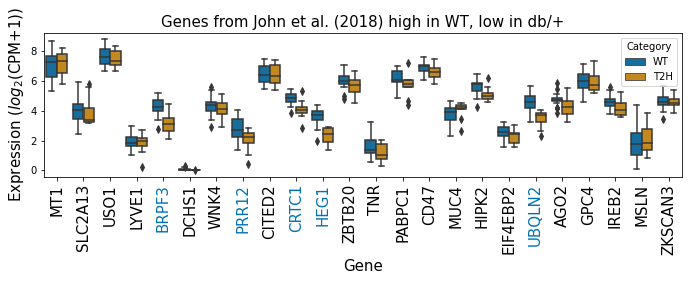

/opt/anaconda3/envs/r-4.0/lib/python3.7/site-packages/ipykernel_launcher.py:110: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_layout" which is no longer supported as of 3.3 and will become an error two minor releases later


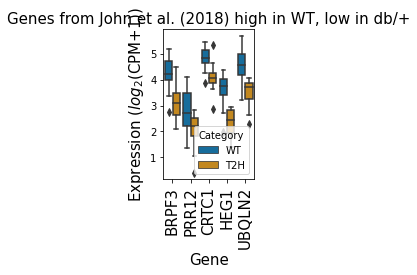

In [68]:
deseq_wt_vs_t2h_df = pd.read_csv('~/Development/anna_karenina_beta_cell/results/WT_vs_T2H.csv', index_col=0)
run_analysis(
    WT_VS_DB_plus_UP_WT, 
    'WT', 
    'T2H', 
    'Genes from John et al. (2018) high in WT, low in db/+',
    deseq_wt_vs_t2h_df,
    './results/genes_from_John_Fig_1C',
    keep_first=True
)

### Figure 1D

/opt/anaconda3/envs/r-4.0/lib/python3.7/site-packages/ipykernel_launcher.py:74: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_layout" which is no longer supported as of 3.3 and will become an error two minor releases later


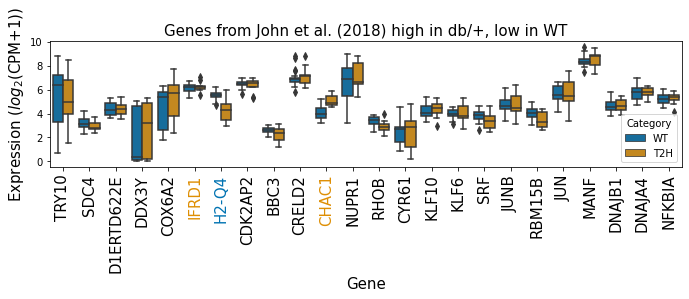

/opt/anaconda3/envs/r-4.0/lib/python3.7/site-packages/ipykernel_launcher.py:109: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
/opt/anaconda3/envs/r-4.0/lib/python3.7/site-packages/ipykernel_launcher.py:110: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_layout" which is no longer supported as of 3.3 and will become an error two minor releases later


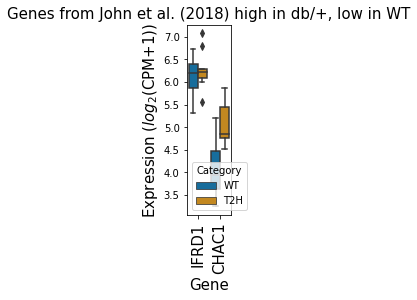

In [69]:
run_analysis(
    WT_VS_DB_plus_UP_DB, 
    'WT', 
    'T2H', 
    'Genes from John et al. (2018) high in db/+, low in WT', 
    deseq_wt_vs_t2h_df,
    './results/genes_from_John_Fig_1D',
    keep_first=False
)

In [70]:
DB_plus_VS_DB_DB_UP_DB_plus = [
    'VDR',
    'GJD2',
    'MAOB',
    'CCND2',
    'TRIM37',
    'LRRC16B', #CARMIL3
    'UCN3',
    'SLC30A8',
    'TRPM5',
    'TFRC',
    'SYTL4',
    'SFRP5',
    #'T2',
    'RASD1',
    'TMEM8',
    'PRSS53',
    'GAD1',
    'PPP1R1A',
    'SLC2A2',
    'HADH',
    'LIFR',
    'ERO1LB',
    'FPGT',
    'COX6A2',
    'GLUL',
    'NR4A1',
    'SLC4A7',
    'LRRN1',
    'CABP7',
    'ZDHHC2',
    'SEPSECS',
    'TSPYL4',
    'NEUROD1',
    'SPHKAP',
    'AP1S2',
    'FKBP1B',
    'INS1',
    'NPAS4',
    'TMEM215',
    'GIPR',
    'TMEM206',
    'MNS1',
    'IVD',
    'ITPKB',
    'JPH3',
    'PCSK9',
    'KCNG3',
    'KCNF1',
    'SCD2',
    'NKX6-1'
    #'ERO1LB'  # This gene appears twice in their figure
]

DB_plus_VS_DB_DB_UP_DB_DB = [
    'C3',
    'PRSS3',
    'RGS5',
    'GPC4',
    'COL5A1',
    'PAMR1',
    'FAM129A',
    'DNAH11',
    'SERPINA7',
    'ARRDC4',
    'INHBB',
    'TNFRSF11B',
    'PON3',
    'FAM167A',
    'LGALS3BP',
    'SORCS2',
    'ALDH1A3',
    'NDUFA1',
    'REG3B',
    'CTHRC1',
    'FKBP11',
    'SEC11C',
    'DIO1',
    'CD24A',
    'ERLEC1',
    'SEMA3C',
    'RHOU',
    'GC',
    'SEL1L3',
    'KDELR3',
    'EDEM2',
    'DAPL1',
    'SLC17A9',
    'TMED3',
    'COL16A1',
    'ITM2C',
    'RASGRF2',
    'COL27A1',
    'CHGB',
    'CCL28',
    'TACC2',
    'SCARF2',
    'NUCB2',
    'BAMBI',
    'HAPLN4',
    'DNAH9',
    'ELL2',
    'PTPRN',
    'SLC26A2',
    'PAPPA2'
]

#print(set(DB_plus_VS_DB_DB_UP_DB_plus) - set(df_counts.index))

#from collections import Counter
#Counter(DB_plus_VS_DB_DB_UP_DB_plus)

### Figure 1F

/opt/anaconda3/envs/r-4.0/lib/python3.7/site-packages/ipykernel_launcher.py:74: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_layout" which is no longer supported as of 3.3 and will become an error two minor releases later


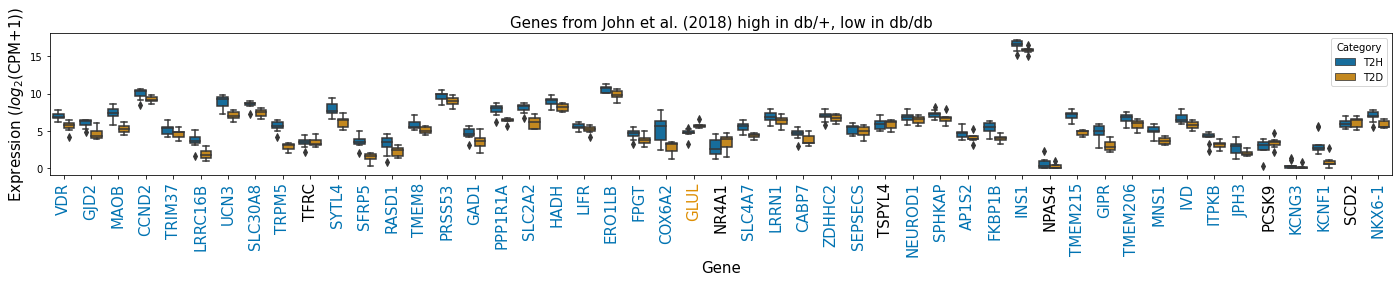

/opt/anaconda3/envs/r-4.0/lib/python3.7/site-packages/ipykernel_launcher.py:110: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_layout" which is no longer supported as of 3.3 and will become an error two minor releases later


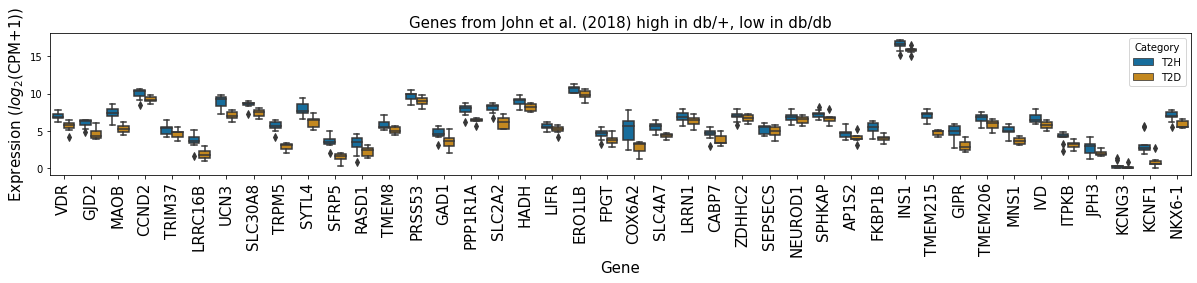

In [71]:
deseq_t2h_vs_t2d_df = pd.read_csv('~/Development/anna_karenina_beta_cell/results/T2H_vs_T2D.csv', index_col=0)
run_analysis(
    DB_plus_VS_DB_DB_UP_DB_plus, 
    'T2H', 
    'T2D', 
    'Genes from John et al. (2018) high in db/+, low in db/db', 
    deseq_t2h_vs_t2d_df,
    './results/genes_from_John_Fig_1F',
    keep_first=True
)

### Figure 1G

/opt/anaconda3/envs/r-4.0/lib/python3.7/site-packages/ipykernel_launcher.py:74: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_layout" which is no longer supported as of 3.3 and will become an error two minor releases later


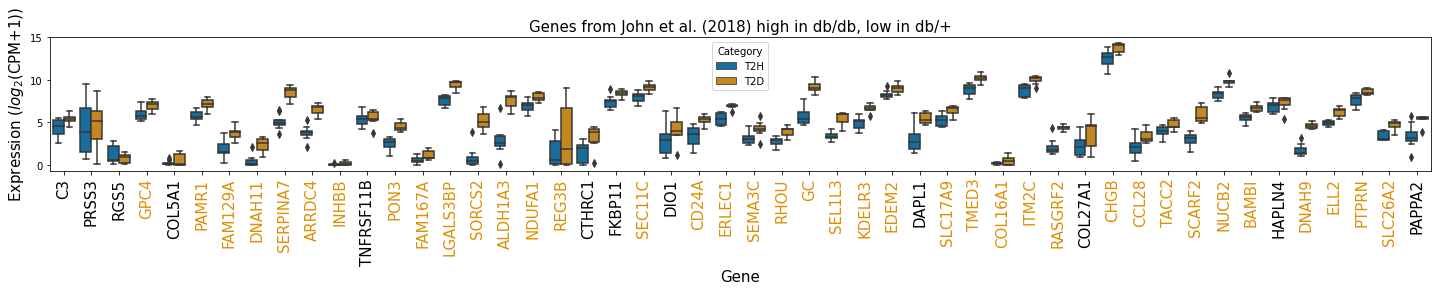

/opt/anaconda3/envs/r-4.0/lib/python3.7/site-packages/ipykernel_launcher.py:110: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_layout" which is no longer supported as of 3.3 and will become an error two minor releases later


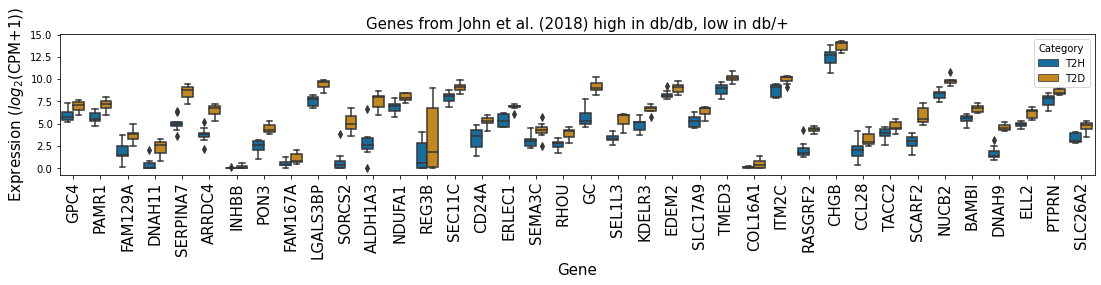

In [72]:
run_analysis(
    DB_plus_VS_DB_DB_UP_DB_DB, 
    'T2H',
    'T2D', 
    'Genes from John et al. (2018) high in db/db, low in db/+', 
    deseq_t2h_vs_t2d_df,
    './results/genes_from_John_Fig_1G',
    keep_first=False
)

In [73]:
WT_VS_DB_DB_UP_WT = [
    'VDR',
    'GIPR',
    'MAOB',
    'FPGT',
    'SCD2',
    'KCNG3',
    'PCSK9',
    'SYTL4',
    'SLC2A2',
    'TRPM5',
    'VWA5B1',
    'SLC30A8',
    'LRRC16B', #CARMIL3
    'GAD1',
    'SPHKAP',
    'SYT14',
    'CABP7',
    'AP1S2',
    'SLC4A7',
    #'T2',
    'FMN2',
    'MAFA',
    'CCND2',
    'ERO1LB',
    'MT1',
    'ABHD2',
    'NKX6-1',
    'FKBP1B',
    'IVD',
    'ITPKB',
    'GJD2',
    'TFRC',
    'PPP1R1A',
    'HADH',
    'PRSS53',
    'UCN3',
    'SFRP5',
    'COX6A2',
    'NPAS4',
    'TMEM215',
    'GLUL',
    'LIFR',
    'TMEM8',
    'CRYL1',
    #'D5ERTD57', # The end of this gene is cut off in the figure
    'TMEM206',
    'MLXIPL',
    'LRRN1',
    'FFAR1',
    'GLP1R',
    'INS1'
]

WT_VS_DB_DB_UP_DB_DB = [
    'CD24A',
    'ARRDC4',
    'GC',
    'RHOU',
    'SEMA3C',
    'DIO1',
    'FAM129A',
    'LGALS3BP',
    'PAMR1',
    'SERPINA7',
    'COL5A1',
    'IGFBP3',
    'COL5A2',
    'ALDH1A3',
    'SORCS2',
    'FAM167A',
    'TNFRSF11B',
    'INHBB',
    'TMED6',
    'PON3',
    'NUCB2',
    'SCARF2',
    'BAMBI',
    'HAPLN4',
    'CCL28',
    'DNAH9',
    'SEL1L3',
    'COL27A1',
    'ITM2C',
    'SERPINI1',
    'SEC11C',
    'KDELR3',
    'GMDS',
    'FKBP11',
    'TMED3',
    'CTHRC1',
    'CHGB',
    'ELL2',
    'PAPPA2',
    'RASGRF2',
    'COL16A1',
    'DAPL1',
    'SIL1',
    'PTPRN',
    'SLC26A2',
    'PRSS1',
    'PRSS3'
]

print(set(WT_VS_DB_DB_UP_DB_DB) - set(df_counts.index))

#from collections import Counter
#Counter(DB_plus_VS_DB_DB_UP_DB_plus)

set()


### Figure 2A

/opt/anaconda3/envs/r-4.0/lib/python3.7/site-packages/ipykernel_launcher.py:74: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_layout" which is no longer supported as of 3.3 and will become an error two minor releases later


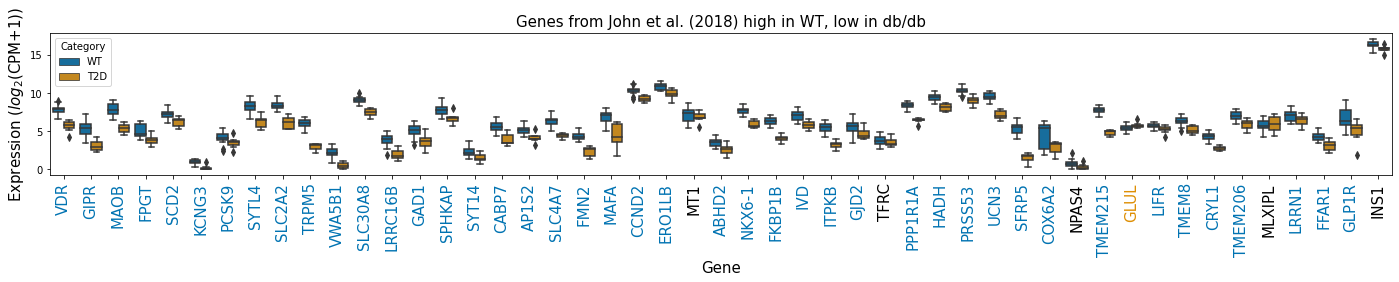

/opt/anaconda3/envs/r-4.0/lib/python3.7/site-packages/ipykernel_launcher.py:110: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_layout" which is no longer supported as of 3.3 and will become an error two minor releases later


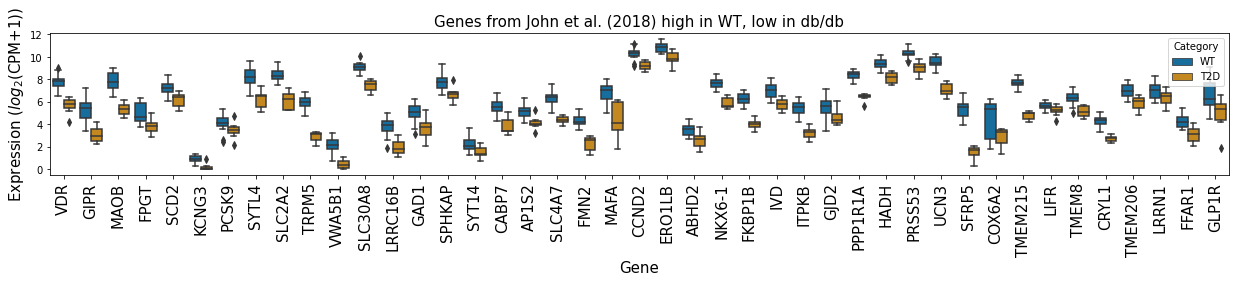

In [74]:
deseq_wt_vs_t2d_df = pd.read_csv('~/Development/anna_karenina_beta_cell/results/WT_vs_T2D.csv', index_col=0)
run_analysis(
    WT_VS_DB_DB_UP_WT, 
    'WT',
    'T2D', 
    'Genes from John et al. (2018) high in WT, low in db/db', 
    deseq_wt_vs_t2d_df,
    './results/genes_from_John_Fig_2A',
    keep_first=True
)

### Figure 2B

/opt/anaconda3/envs/r-4.0/lib/python3.7/site-packages/ipykernel_launcher.py:74: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_layout" which is no longer supported as of 3.3 and will become an error two minor releases later


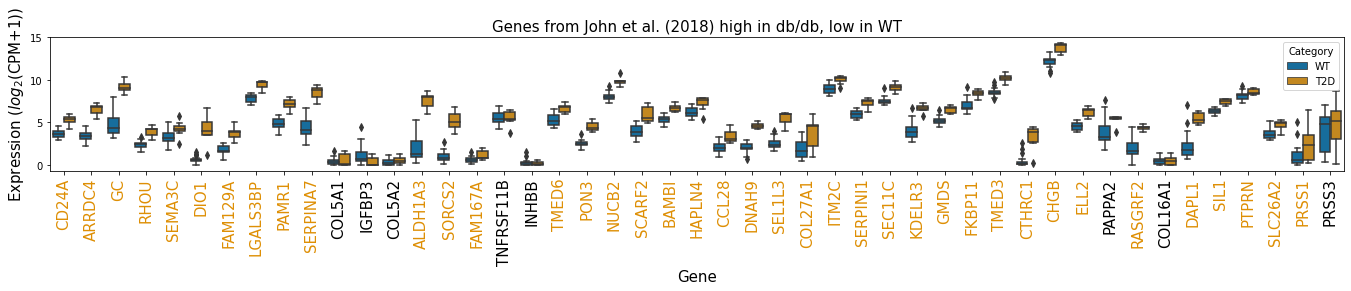

/opt/anaconda3/envs/r-4.0/lib/python3.7/site-packages/ipykernel_launcher.py:110: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_layout" which is no longer supported as of 3.3 and will become an error two minor releases later


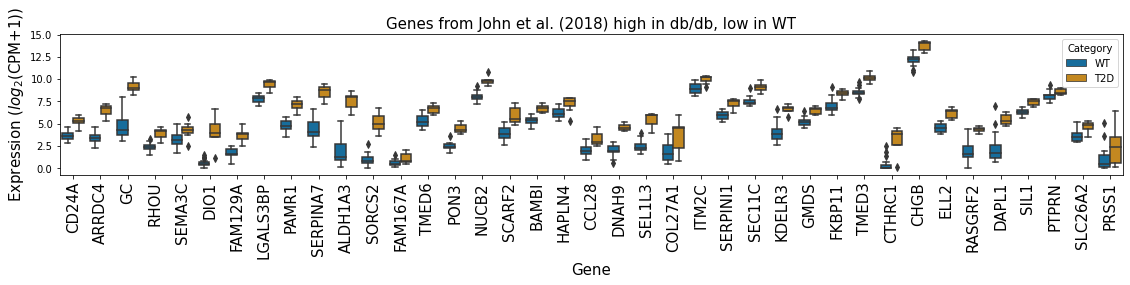

In [75]:
run_analysis(
    WT_VS_DB_DB_UP_DB_DB, 
    'WT',
    'T2D', 
    'Genes from John et al. (2018) high in db/db, low in WT', 
    deseq_wt_vs_t2d_df,
    './results/genes_from_John_Fig_2B',
    keep_first=False
)